<img src="../img/gcam_banner.png" alt="Powered by MSD-LIVE" width = 800 style="display: block;margin-left: auto;margin-right: auto;width: 80%;" />


</br>

<img src="../img/gcam_demeter_cover_slide.png" alt="Cover slide" width = 1000 style="display: block;margin-left: auto;margin-right: auto;width: 100%;" />


</br>

## Introduction

Researchers and decision makers are increasingly interested in understanding the many ways in which human and Earth systems interact with one another, at scales from regional to global. For example, how might changes in population, income, or technology development alter crop production, energy demand, or water withdrawals? How do changes in one region's demand for energy affect energy, water, and land in other regions? This session will focus on two models – GCAM and Demeter – that provide capabilities to address these types of questions.


GCAM is an open-source, global, market equilibrium model that represents the linkages between energy, water, land, climate, and economic systems. A strength of GCAM is that it can be used to quickly explore, and quantify the uncertainty in, a large number of alternate future scenarios while accounting for multisector dynamics. One of GCAM’s many outputs is projected land cover/use by subregion. Subregional projections provide context and can be used to understand regional land dynamics; however, Earth System Models (ESMs) generally require gridded representations of land at finer scales. Demeter, a land use and land cover disaggregation model, was created to provide this service. Demeter directly ingests land projections from GCAM and creates gridded products that match the desired resolution and land class requirements of the user.

This tutorial will introduce `gcamwrapper`, a Python wrapper for GCAM, to provide a hands-on walk through for a reference case so you can become familiar with configuring and running these two models while having the ability to update GCAM's parameters on a time-step by time-step basis. Our goal will be to demonstrate how to integrate GCAM - using its new Python wrapper - into existing workflows that research energy, water, land, climate, and socioeconomic dynamics to provide a global, human-Earth systems perspective.


## Software Availability

Demeter: https://github.com/JGCRI/demeter  
GCAM: https://github.com/JGCRI/gcam-core  
gcamwrapper: https://github.com/JGCRI/gcamwrapper  
im3vis: https://github.com/IMMM-SFA/im3vis


## Overview of the experiment to demonstrate capabilities

For this demonstration we will attempt to incorporate climate-induced yield impacts in GCAM.  To do so we will utilize an archive of global gridded crop model results published as part of the [ISI-MIP](https://doi.org/10.1073/pnas.1222463110) project.  Though this exercise has been conducted before ([Snyder 2020](https://doi.org/10.1371/journal.pone.0237918), [Calvin 2020](https://doi.org/10.1142/S2010007820500050)), a shortcoming identified in the design of these experiments is that they assume a fixed spatial distribution of crop production which is used to weight the gridded yield impacts.  Similar studies have indicated missing this dynamic can create significant bias ([Fujimori 2018](https://doi.org/10.3390/su10103673)).

We can use the dynamic GCAM-Demeter coupling to address this insufficiency by updating the spatial distribution of cropland to evolve with future scenario conditions. This is what we will to do in this demonstration with the caveat that simplifying assumptions were made to ensure computational tractability for illustrative purposes.


## Outline

- Load and initialize GCAM through its calibration years
  - Visualize GCAM regional land use and cover
- Use Demeter to downscale GCAM land use to a 0.5-degree resolution to match the resolution of the ISI-MIP crop yield data
- Run and query the first projected GCAM year _without_ climate impacts
  - Create a baseline for comparison
- Load ISI-MIP yields and apply weights using Demeter's gridded crop downscaled data
- Update GCAM with the adjusted yield impacts and re-run the first projected year _with_ climate impacts
- Compare results with and without climate impacts

## Import packages

In [14]:
# general purpose package
import time
import pkg_resources

import pandas as pd
import geopandas as gpd

# load demeter and GCAM via gcamwrapper
import demeter
from demeter import Model
import gcamwrapper as gw

# some utilities to help keep the notebook tidy
import im3vis
import demo_utils
import gcam_demeter_clinic


## Using GCAM via `gcamwrapper`

#### See help documentation

In [15]:
help(gw.Gcam)

Help on class Gcam in module gcamwrapper.main:

class Gcam(gcam_module.gcam)
 |  A wrapper around GCAM to interactively run a scenario and use
 |  GCAMFusion capabilities to get/set arbitrary data from a running
 |  instance.
 |  
 |  Method resolution order:
 |      Gcam
 |      gcam_module.gcam
 |      Boost.Python.instance
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  convert_period_to_year(self, period)
 |      Convert from a GCAM model period to year
 |      
 |      :param period: The model period to convert to year
 |      :type period: integer or list of integer
 |      
 |      :returns: The corresponding model year(s)
 |  
 |  convert_year_to_period(self, year)
 |      Convert from a GCAM model year to model period
 |      
 |      :param year: The model year to convert to period
 |      :type year:integer or list of integer
 |      
 |      :returns: The corresponding model period(s)
 |  
 |  create_solution_debugger(self, period=None)
 |      Create a solu

#### Load GCAM specific files

In [12]:
# path to the exe directory where gcam-core is installed
core_exe_path = 'gcam-core/exe'

# path to the xml configuration file you want to use
config_xml_file = 'configuration_reduced.xml'


#### Instantiate GCAM

In [ ]:
#%%time

gcam = gw.Gcam(config_xml_file, core_exe_path)


Running GCAM model code base version 5.3 revision gcam-v5.3

Configuration file:  configuration_reduced.xml
Parsing input files...
ERROR:Modeltime can only be parsed once.
Parsing ../input/gcamdata/xml/no_climate_model.xml scenario component.
Parsing ../input/gcamdata/xml/socioeconomics_gSSP2.xml scenario component.
Parsing ../input/gcamdata/xml/resources.xml scenario component.
Parsing ../input/gcamdata/xml/en_supply.xml scenario component.
Parsing ../input/gcamdata/xml/en_transformation.xml scenario component.
Parsing ../input/gcamdata/xml/electricity.xml scenario component.
Parsing ../input/gcamdata/xml/heat.xml scenario component.
Parsing ../input/gcamdata/xml/hydrogen.xml scenario component.
Parsing ../input/gcamdata/xml/en_distribution.xml scenario component.
Parsing ../input/gcamdata/xml/industry.xml scenario component.
Parsing ../input/gcamdata/xml/industry_incelas_gssp2.xml scenario component.
Parsing ../input/gcamdata/xml/cement.xml scenario component.
Parsing ../input/gcamda

#### Run the model through its calibration years through the base year of 2015

In [5]:
%%time

final_cal_period = gcam.convert_year_to_period(2015)
gcam.run_to_period(final_cal_period)


Starting a model run. Running period 4
Model run beginning.
Period 0: 1975
Model solved with last period's prices.

Period 1: 1990
Model solved normally. Iterations period 1: 1. Total iterations: 2

Period 2: 2005
Model solved normally. Iterations period 2: 1. Total iterations: 3

Period 3: 2010
Model solved normally. Iterations period 3: 1. Total iterations: 4

Period 4: 2015
Model solved normally. Iterations period 4: 1. Total iterations: 5

All model periods solved correctly.
Model run completed.
CPU times: user 32.8 s, sys: 192 ms, total: 33 s
Wall time: 32.9 s


#### Query land allocation data from the current GCAM run to produce projected land allocation by land region

In [6]:
# load query from query library
query_string = gw.get_query('land', 'land_allocation')

# query specific information
query_params = {'region': ['*'], 'leaf': ['*'], 'year': ['<=', gcam.get_current_year()]}

# create an output data frame containing land data
land_df = gcam.get_data(query_string, query_params)

land_df.head()


,region,child-nodes,year,land-allocation
0,Africa_Eastern,Corn_AfrCstE_IRR_hi,1975,0.009381
1,Africa_Eastern,Corn_AfrCstE_IRR_hi,1990,0.008705
2,Africa_Eastern,Corn_AfrCstE_IRR_hi,2005,0.010365
3,Africa_Eastern,Corn_AfrCstE_IRR_hi,2010,0.012348
4,Africa_Eastern,Corn_AfrCstE_IRR_hi,2015,0.013194


## Explore GCAM land allocation outputs for year 2015

#### Load into a demeter formatted dataframe

In [7]:
gcam_df = demeter.format_gcam_data(df=land_df, start_year=2015, through_year=2015)

gcam_df.head()


,region,glu_name,region_id,metric_id,landclass,2015
0,Africa_Eastern,AfrCstE,2,171.0,Corn_IRR,0.026389
1,Africa_Eastern,AfrCstE,2,171.0,Corn_RFD,8.827320
2,Africa_Eastern,AfrCstE,2,171.0,FiberCrop_IRR,0.021205
3,Africa_Eastern,AfrCstE,2,171.0,FiberCrop_RFD,0.189931
4,Africa_Eastern,AfrCstE,2,171.0,Forest,4.855879


#### GCAM total land allocation by region for all land classes

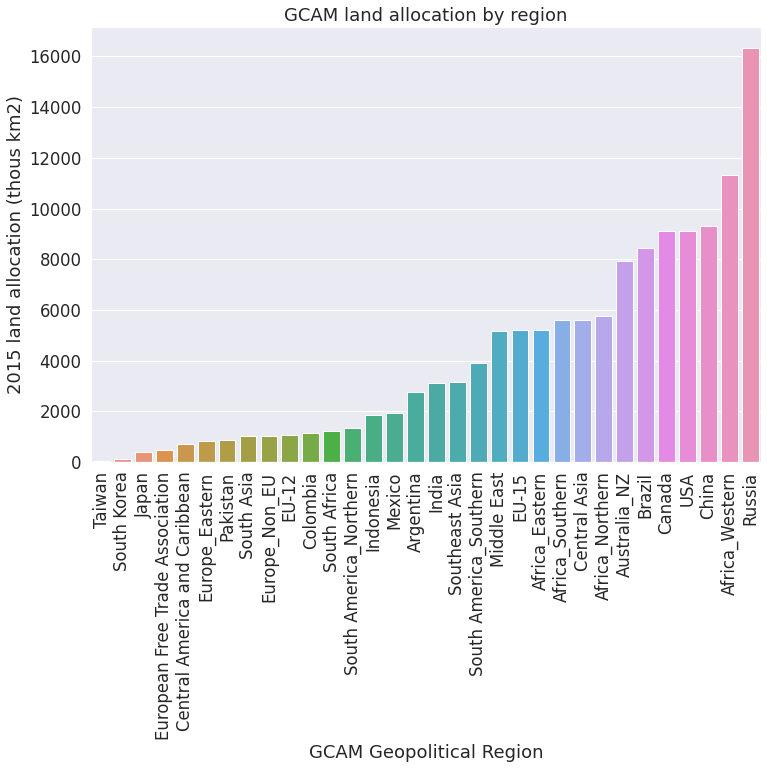

In [9]:
reg_ax = im3vis.gcam_demeter_region(gcam_df, 
                                    target_year='2015',
                                    label='land allocation', 
                                    units=land_df.attrs['units'])


#### GCAM total land allocation by region for combined Corn

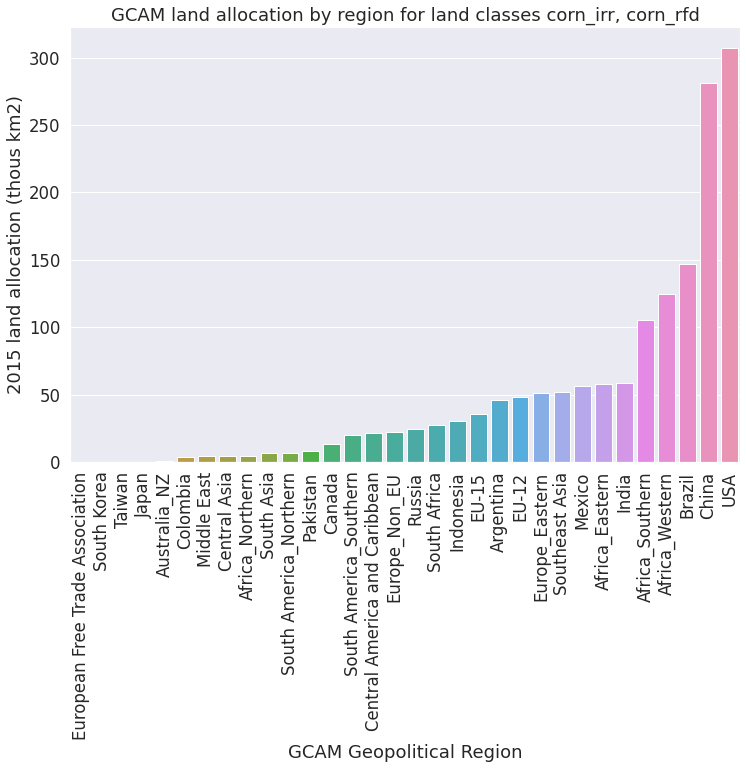

In [10]:
reg_ax = im3vis.gcam_demeter_region(gcam_df, 
                                    target_year='2015', 
                                    landclass_list=['corn_irr', 'corn_rfd'],
                                    label='land allocation', 
                                    units=land_df.attrs['units'])


#### GCAM `corn` allocation for year 2015 for the CONUS

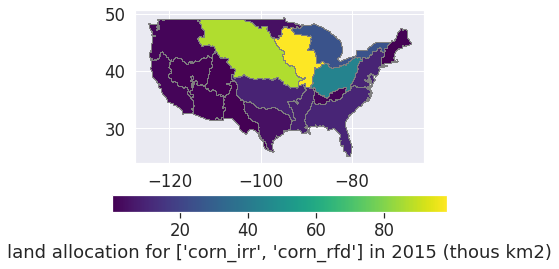

In [11]:
agg_df = im3vis.plot_gcam_basin(gcam_df,
                                target_year='2015',
                                landclass_list=['corn_irr', 'corn_rfd'],
                                setting='crop_yield',
                                scope='conus',
                                label='land allocation', 
                                units=land_df.attrs['units'])


#### GCAM `corn` allocation for year 2015 for global basins

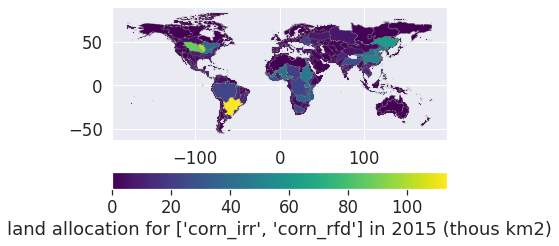

In [12]:
agg_df = im3vis.plot_gcam_basin(gcam_df,
                                target_year='2015',
                                landclass_list=['corn_irr', 'corn_rfd'],
                                setting='crop_yield',
                                scope='global',
                                label='land allocation', 
                                units=land_df.attrs['units'])


## Run Demeter

#### Instantiate Demeter

In [13]:
# instantiate demeter model
model = Model(config_file=gcam_demeter_clinic.get_config_file(), 
              gcamwrapper_df=land_df,
              write_outputs=False,
              write_logfile=False)


2021-07-08 03:28:47,822 - demeter_runtime - INFO - Using `observed_lu_file`:  /home/msdadmin/csdms_demo/demeter_data/inputs/observed/gcam_reg32_basin235_modis_v6_2010_mirca_2000_0p5deg_sqdeg_wgs84_07may2021.csv
2021-07-08 03:28:47,824 - demeter_runtime - INFO - Using `run_dir`:  /home/msdadmin/csdms_demo/demeter_data


#### Load model data and prepare run

In [14]:
model.initialize()


2021-07-08 03:28:53,758 - demeter_runtime - INFO - START
2021-07-08 03:28:53,760 - demeter_runtime - INFO - Reading allocation input files...
2021-07-08 03:28:53,786 - demeter_runtime - INFO - PERFORMANCE:  Allocation files processed in 0.025371074676513672 seconds
2021-07-08 03:28:53,789 - demeter_runtime - INFO - Preparing projected land use data...
2021-07-08 03:28:53,790 - demeter_runtime - INFO - Using projected GCAM data from `gcamwrapper` data frame
2021-07-08 03:28:53,920 - demeter_runtime - INFO - Number of regions from projected file:  33
2021-07-08 03:28:53,921 - demeter_runtime - INFO - Number of basins from projected file:  231
2021-07-08 03:28:53,921 - demeter_runtime - INFO - PERFORMANCE:  Projected landuse data prepared in 0.13150262832641602 seconds
2021-07-08 03:28:53,922 - demeter_runtime - INFO - Preparing base layer land use data...
2021-07-08 03:28:54,280 - demeter_runtime - INFO - PERFORMANCE:  Base spatial landuse data prepared in 0.3576366901397705 seconds
2021

#### Process the target time step from the GCAM output DataFrame for land allocation

In [15]:
%%time

# process first year
demeter_2015 = model.process_step()


2021-07-08 03:29:08,661 - demeter_runtime - INFO - Applying intensification: pass 1 for time step 2015...
2021-07-08 03:29:27,022 - demeter_runtime - INFO - Applying expansion for time step 2015...
2021-07-08 03:29:40,248 - demeter_runtime - INFO - Applying intensification: pass 2 for time step 2015...
2021-07-08 03:29:46,226 - demeter_runtime - INFO - Generating projected land cover data for time step 2015...
CPU times: user 42.4 s, sys: 1.51 s, total: 43.9 s
Wall time: 43.9 s


## Explore Demeter's outputs

#### Build a geodataframe from the outputs

In [16]:
# a geopandas data frame of demeter's output land allocation data with geometry
demeter_gdf = im3vis.build_geodataframe(demeter_2015)


#### Plot Demeter `corn` output for year 2015 for the CONUS

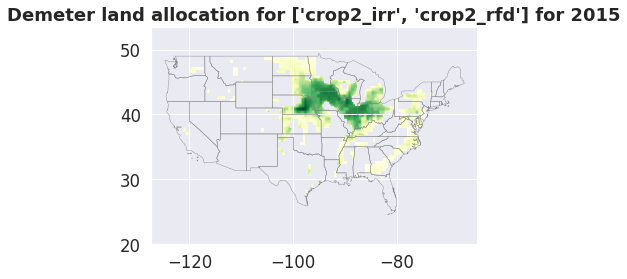

In [17]:
r = im3vis.plot_demeter_raster(demeter_gdf=demeter_gdf, 
                               landclass_list=['crop2_irr', 'crop2_rfd'],
                               target_year='2015', 
                               scope='conus',
                               resolution='0.5')


#### Plot Demeter `forest` global output for 2015

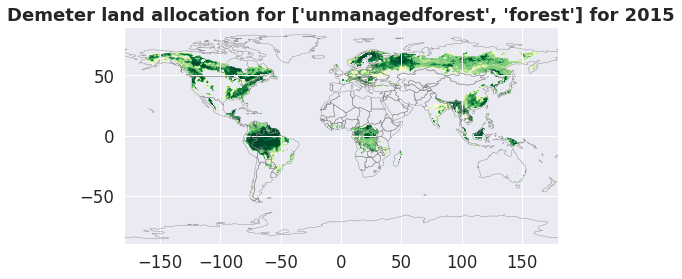

In [18]:
r = im3vis.plot_demeter_raster(demeter_gdf=demeter_gdf, 
                               landclass_list=['unmanagedforest', 'forest'],
                               target_year='2015', 
                               scope='global',
                               resolution='0.5')


#### Clean up the logger

In [19]:
model.cleanup()


2021-07-08 03:30:39,843 - demeter_runtime - INFO - END


## Run the next model period (2020) in GCAM _without_ yield impacts

In [20]:
%%time

gcam.run_to_period()


Starting a model run. Running period 5
Model run beginning.
Period 5: 2020
Model solved normally. Iterations period 5: 938. Total iterations: 943

All model periods solved correctly.
Model run completed.
CPU times: user 3min 9s, sys: 280 ms, total: 3min 9s
Wall time: 3min 9s


#### Query and visualize model results _without_ accounting for yield impact for comparison purposes

In [21]:
# load query for land allocation
query_string = gw.get_query('land', 'land_allocation')
query_params = {'region': ['*'], 'leaf': ['*'], 'year': ['<=', gcam.get_current_year()]}

# run the query
land_df = gcam.get_data(query_string, query_params)

# get Corn producer prices
query_string = gw.get_query('ag', 'prices')
query_params = {'region': ['*'], 
                'sector': ['=', 'Corn'], 
                'year': ['=', gcam.get_current_year()]}

prod_prices = gcam.get_data(query_string, query_params)

# get domestic Corn prices (accounting for trade)
query_params['sector'] = ["=", 'regional corn']

dom_prices = gcam.get_data(query_string, query_params)

# get crop production data
query_string = gw.get_query('ag', 'production')
query_params = {'region': ['*'],
                'sector': ['*'],
                'year': ['=', gcam.get_current_year()]}
production = gcam.get_data(query_string, query_params)

# finally get the actual yields
query_string = gw.get_query('ag', 'yield')
query_params = {'region': ['*'], 
                'sector': ['*'], 
                'tech': ['*'], 
                'year': ['=', gcam.get_current_year()]}

yields = gcam.get_data(query_string, query_params)


## Generate yield impacts from ISI-MIP PDSST data using downscaled land from Demeter to weight and map them to GCAM land regions

#### Use Demeter downscaled outputs to build crop yield scalers

In [22]:
yield_scaler_df = demo_utils.get_yield_scalers(demeter_2015, gcam.get_current_year())

yield_scaler_df.head()


,region,sector,subsector,technology,year,yield_scaler
0,USA,Wheat,Wheat_NelsonR,Wheat_NelsonR_IRR_hi,2020,1.202267
1,USA,Wheat,Wheat_MexCstNW,Wheat_MexCstNW_IRR_hi,2020,0.765466
2,USA,Wheat,Wheat_California,Wheat_California_IRR_hi,2020,0.938177
3,USA,Wheat,Wheat_MissppRN,Wheat_MissppRN_IRR_hi,2020,0.888875
4,USA,Wheat,Wheat_MissppRS,Wheat_MissppRS_IRR_hi,2020,0.911265


#### Apply the yield scaler to the ISI-MIP data

In [23]:
yields_new = yields.merge(yield_scaler_df, on=["region", "sector", "technology", "year"], how="inner")

yields_new['yield'] *= yields_new['yield_scaler']

yields_new = yields_new.filter(["region", "sector", "technology", "year", "yield"])

yields_new.head()


,region,sector,technology,year,yield
0,Africa_Eastern,Corn,Corn_AfrCstE_IRR_hi,2020,0.127408
1,Africa_Eastern,Corn,Corn_AfrCstE_IRR_lo,2020,0.084936
2,Africa_Eastern,Corn,Corn_AfrCstE_RFD_hi,2020,0.116881
3,Africa_Eastern,Corn,Corn_AfrCstE_RFD_lo,2020,0.077921
4,Africa_Eastern,Corn,Corn_AfrCstNE_IRR_hi,2020,0.022856


## Update yields in GCAM for year 2020 and run _with_ climate impacts

In [24]:
# get the same query string
query_string = gw.get_query('ag', 'yield')

# however the syntax for the query params are slightly different for set data as we
# need to explicitly tell it which match with the '+' argument and of course we do
# not give the values to compare against as those are coming from the DataFrame
query_params = {'region': ['+', '='], 
                'sector': ['+', '='], 
                'tech': ['+', '='], 
                'year': ['+', '=']}

gcam.set_data(yields_new, query_string, query_params)

# re-run 2020
gcam.run_to_period(gcam.get_current_period())


Starting a model run. Running period 5
Model run beginning.
Period 5: 2020
Model solved normally. Iterations period 5: 360. Total iterations: 1302

All model periods solved correctly.
Model run completed.


## Get the results _with_ impacts for comparison

In [25]:
# load query for land allocation
query_string = gw.get_query('land', 'land_allocation')
query_params = {'region': ['*'], 
                'leaf': ['*'], 
                'year': ['<=', gcam.get_current_year()]}

# run the query
land_df_new = gcam.get_data(query_string, query_params)

# get Corn producer prices
query_string = gw.get_query('ag', 'prices')
query_params = {'region': ['*'], 
                'sector': ['=', 'Corn'], 
                'year': ['=', gcam.get_current_year()]}

prod_prices_new = gcam.get_data(query_string, query_params)

# get domestic Corn prices (accounting for trade)
query_params['sector'] = ["=", 'regional corn']

dom_prices_new = gcam.get_data(query_string, query_params)

# get crop production data
query_string = gw.get_query('ag', 'production')
query_params = {'region': ['*'],
                'sector': ['*'],
                'year': ['=', gcam.get_current_year()]}

production_new = gcam.get_data(query_string, query_params)

# finally get the actual yields
query_string = gw.get_query('ag', 'yield')
query_params = {'region': ['*'], 
                'sector': ['*'], 
                'tech': ['*'], 
                'year': ['=', gcam.get_current_year()]}

yields_new = gcam.get_data(query_string, query_params)


## Compare 2020 GCAM outputs _with_ and _without_ crop yield updates

#### Difference in corn producer prices by region _with_ and _without_ considering climate impacts

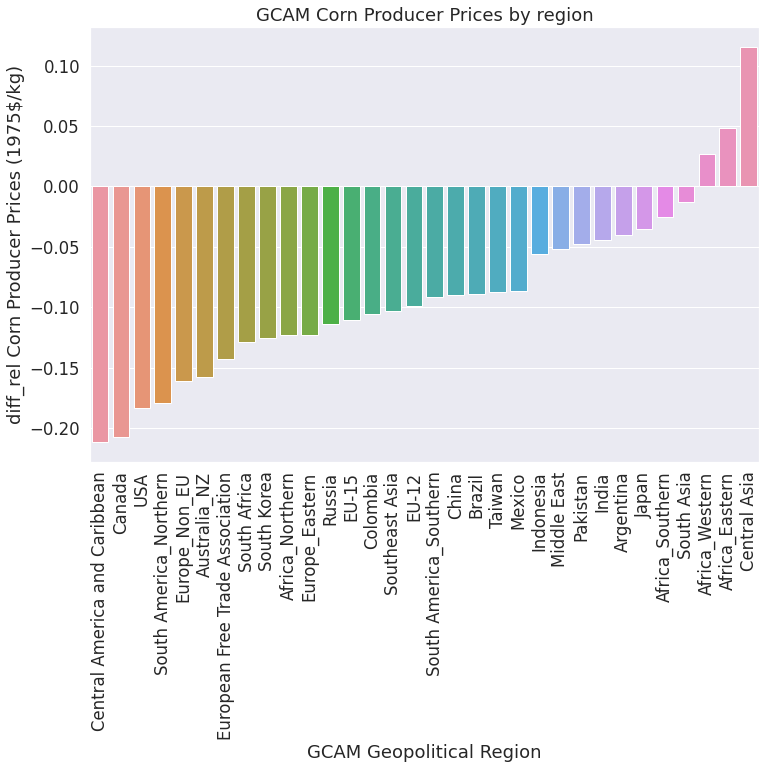

In [26]:
prod_prices_diff = demo_utils.calc_diff(prod_prices_new, prod_prices)

reg_ax = im3vis.gcam_demeter_region(prod_prices_diff, 
                                    target_year='diff_rel', 
                                    metric_id_col=None,
                                    label='Corn Producer Prices', 
                                    units=prod_prices.attrs['units'])


#### Difference in corn domestic prices by region _with_ and _without_ considering climate impacts

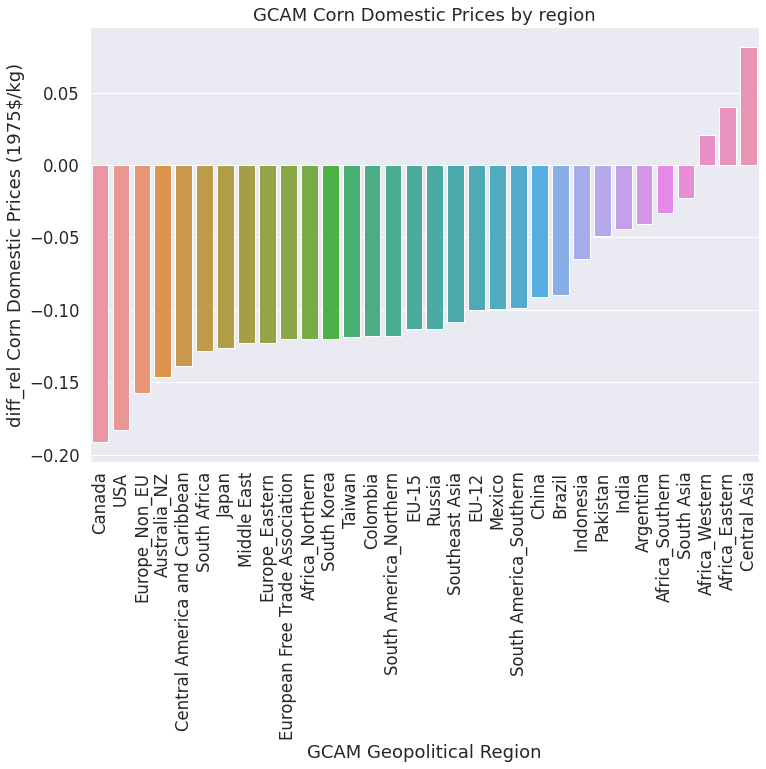

In [27]:
dom_prices_diff = demo_utils.calc_diff(dom_prices_new, dom_prices)

reg_ax = im3vis.gcam_demeter_region(dom_prices_diff, 
                                    target_year='diff_rel', 
                                    metric_id_col=None,
                                    label='Corn Domestic Prices', 
                                    units=prod_prices.attrs['units'])


#### Difference in corn yield globally _with_ and _without_ considering climate impacts

In [1]:
yields_diff = demo_utils.calc_diff(yields_new, yields)

yields_diff = yields_diff.query("sector == 'Corn'")

yields_plotdf = demeter.format_gcam_data(df=yields_diff, start_year=2020, through_year=2020, gcam_landalloc_field="diff_rel", gcam_nodes_field="technology")

yields_plotdf_irr = yields_plotdf.query('landclass == "Corn_IRR"').copy()

agg_df = im3vis.plot_gcam_basin(yields_plotdf_irr,
                                target_year='2020',
                                landclass_list=['corn_irr'],
                                setting='crop_yield',
                                scope='global',
                                label="Yield Relative Diff",
                                units=yields.attrs['units'])

yields_plotdf_rfd = yields_plotdf.query('landclass == "Corn_RFD"').copy()

agg_df = im3vis.plot_gcam_basin(yields_plotdf_rfd,
                                target_year='2020',
                                landclass_list=['corn_rfd'],
                                setting='crop_yield',
                                scope='global',
                                label="Yield Relative Diff",
                                units=yields.attrs['units'])


NameError: name 'demo_utils' is not defined

#### Difference in corn production globally _with_ and _without_ considering climate impacts

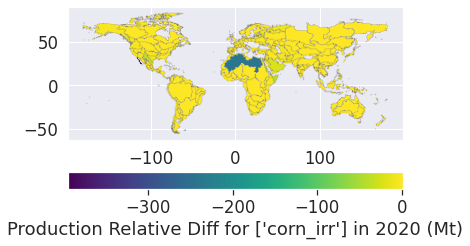

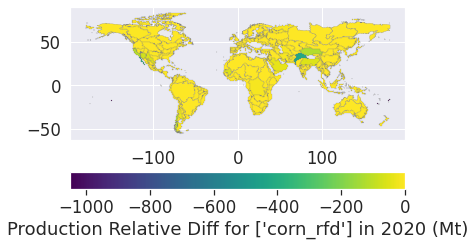

In [29]:
production_diff = demo_utils.calc_diff(production_new, production)

production_diff = production_diff.query("sector == 'Corn'")

production_plotdf = demeter.format_gcam_data(df=production_diff, start_year=2020, through_year=2020, gcam_landalloc_field="diff_rel", gcam_nodes_field="technology")

production_plotdf_irr = production_plotdf.query('landclass == "Corn_IRR"').copy()

agg_df = im3vis.plot_gcam_basin(production_plotdf_irr,
                                target_year='2020',
                                landclass_list=['corn_irr'],
                                setting='crop_yield',
                                scope='global',
                                label="Production Relative Diff",
                                units=production.attrs['units'])

production_plotdf_rfd = production_plotdf.query('landclass == "Corn_RFD"').copy()

agg_df = im3vis.plot_gcam_basin(production_plotdf_rfd,
                                target_year='2020',
                                landclass_list=['corn_rfd'],
                                setting='crop_yield',
                                scope='global',
                                label="Production Relative Diff",
                                units=production.attrs['units'])


## Thank you!

Hopefully we provided a high-level demonstration of how to integrate GCAM - using its new Python wrapper - into existing workflows that research energy, water, land, climate, and socioeconomic dynamics to provide a global, human-Earth perspective.


## Please feel free to contact us for any further questions at:


#### chris.vernon@pnnl.gov
#### pralit.patel@pnnl.gov

## Acknowledgement

This research was supported by the U.S. Department of Energy, Office of Science, as part of research in MultiSector Dynamics, Earth and Environmental System Modeling Program. The Pacific Northwest National Laboratory is operated for DOE by Battelle Memorial Institute under contract DE-AC05-76RL01830. The views and opinions expressed in this paper are those of the authors alone.
